# Introduction

Create a binary classifier using the `features_20240217_v1` features dataset. The dataset contains predicted and actual values with the same feature name. The prefix marks the source of the value. Use actual values for training and predicted values for testing.

In [1]:
import re
import tempfile
import warnings

import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from JapanHorseRaceAnalytics.utilities.base import get_base_dir, get_data_dir
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_binary_classifier_statistics,
)
from JapanHorseRaceAnalytics.utilities.mlflow import get_colspecs
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# Data Collection

In [2]:
warehouse_dir = f"{get_base_dir()}/spark-warehouse"
postgres_driver_path = f"{get_base_dir()}/jars/postgresql-42.7.1.jar"

spark = (
    SparkSession.builder.appName("20240211_competitors")
    .config("spark.driver.memory", "21g")
    .config("spark.driver.maxResultSize", "5g")
    .config("spark.sql.warehouse.dir", warehouse_dir)
    .config("spark.jars", postgres_driver_path)
    .config("spark.executor.extraClassPath", postgres_driver_path)
    .config("spark.driver.extraClassPath", postgres_driver_path)
    .enableHiveSupport()
    .getOrCreate()
)

24/02/18 10:45:39 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/02/18 10:45:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/02/18 10:45:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/18 10:45:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
def read_hive_table(
    table_name: str,
    schema: str,
    spark_session: SparkSession,
    use_cache: bool = True,
):
    save_path = get_data_dir() / "sql_tables" / f"{table_name}.snappy.parquet"
    if use_cache and save_path.exists():
        logger.info(f"Read from parquet {save_path} to pandas")
        return pd.read_parquet(save_path)
    logger.info(f"Read from hive {schema}.{table_name}")
    spark_df = spark_session.read.table(f"{schema}.{table_name}")
    logger.info(f"Write to parquet {save_path}")
    spark_df.write.mode("overwrite").parquet(str(save_path))
    logger.info(f"Read from parquet {save_path} to pandas")
    return pd.read_parquet(save_path)


data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
)

# Set the dtype of all columns beginning with cat_ to category
data = data.astype(
    {col: "category" for col in data.columns if re.match(r"^cat_", col) and col}
)
# Set the dtype of all columns beginning with num_ to float64
data = data.astype(
    {col: "float64" for col in data.columns if re.match(r"^num_", col) and col}
)

data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-02-18T01:45:40.087901Z", "logger": "__main__"}


,meta_レースキー,meta_馬番,meta_着順,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_発走日時,meta_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,cat_事前_レース条件_トラック情報_右左,cat_事前_レース条件_トラック情報_内外,cat_事前_レース条件_種別,cat_事前_レース条件_条件,cat_事前_レース条件_記号,cat_事前_レース条件_重量,cat_事前_レース条件_グレード,num_事前_頭数,cat_実績_馬場状態コード,cat_実績_レース条件_トラック情報_右左,cat_実績_レース条件_トラック情報_内外,cat_実績_レース条件_種別,cat_実績_レース条件_条件,cat_実績_レース条件_記号,cat_実績_レース条件_重量,cat_実績_レース条件_グレード,num_実績_頭数,cat_トラック種別,num_事前_馬場差,num_実績_馬場差,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,cat_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,num_事前_馬体重,...,num_競争相手平均調教師トップ3完走率差,num_競争相手平均調教師場所レース数差,num_競争相手平均調教師場所1位完走差,num_競争相手平均調教師場所トップ3完走差,num_競争相手平均調教師場所1位完走率差,num_競争相手平均調教師場所トップ3完走率差,num_競争相手平均調教師本賞金累計差,num_競争相手平均調教師1位完走平均賞金差,num_競争相手平均調教師レース数平均賞金差,meta_int_combinations_レースキー,meta_int_combinations_馬番,num_馬騎手レース数,num_馬騎手1位完走,num_馬騎手1位完走率,num_馬騎手トップ3完走,num_馬騎手トップ3完走率,num_馬騎手初二走,num_馬騎手同騎手,num_馬騎手場所レース数,num_馬騎手場所1位完走,num_馬騎手場所1位完走率,num_馬騎手場所トップ3完走,num_馬騎手場所トップ3完走率,num_馬調教師レース数,num_馬調教師1位完走,num_馬調教師1位完走率,num_馬調教師トップ3完走,num_馬調教師トップ3完走率,num_馬調教師初二走,num_馬調教師同調教師,num_馬調教師場所レース数,num_馬調教師場所1位完走,num_馬調教師場所1位完走率,num_馬調教師場所トップ3完走,num_馬調教師場所トップ3完走率,meta_int_race_weather_レースキー,num_temperature,num_precipitation,num_snowfall,num_snow_depth,num_wind_speed,cat_wind_direction,num_solar_radiation,num_local_air_pressure,num_sea_level_air_pressure,num_relative_humidity,num_vapor_pressure,num_dew_point_temperature,cat_weather,num_visibility
0,01011103,04,6.0,0.0,False,0,False,0,01011103,2001-08-04 01:45:00,01,3,1200,20,1,1,12,A3,102,3,NaN,16.0,21,1,1,12,A3,102,3,NaN,16.0,芝,NaN,-18.0,1,1,1,1.0,1.0,0.0,0.0,0.0,NaN,NaN,False,False,NaN,01011103,04,476.0,...,-0.036119,-6.733333,-1.066667,-0.733333,-0.010847,0.125590,-18662.266667,-159.225818,-51.509013,01011103,04,2.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,0.111111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,01011103,22.800,0.0,NaN,0.0,3.900,北西,2.9300,1010.950,1013.950,60.75,16.875,14.850,NaN,NaN
1,01011103,09,2.0,200.0,False,0,True,120,01011103,2001-08-04 01:45:00,01,3,1200,20,1,1,12,A3,102,3,NaN,16.0,21,1,1,12,A3,102,3,NaN,16.0,芝,NaN,-18.0,1,1,1,1.0,1.0,0.0,0.0,0.0,NaN,NaN,False,False,NaN,01011103,09,482.0,...,-0.068150,-9.933333,-1.066667,-1.800000,0.018783,0.125590,-28766.800000,-206.365603,-72.468494,01011103,09,3.0,0.0,0.0,2.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,3.0,0.375000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,01011103,22.800,0.0,NaN,0.0,3.900,北西,2.9300,1010.950,1013.950,60.75,16.875,14.850,NaN,NaN
2,01011204,14,6.0,0.0,False,0,False,0,01011204,2001-08-05 02:15:00,01,3,1800,10,1,1,12,A3,102,3,NaN,14.0,11,1,1,12,A3,102,3,NaN,14.0,芝,NaN,-14.0,1,1,1,1.0,1.0,0.0,0.0,0.0,NaN,NaN,False,False,NaN,01011204,14,470.0,...,0.049687,15.769231,6.846154,9.923077,0.137634,0.149950,49377.500000,316.358601,86.088353,01011204,14,4.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,0.100000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,01011204,22.300,0.0,NaN,0.0,4.625,北北西,3.1400,1010.325,1013.325,64.00,17.225,15.150,1,30.0
3,01011303,06,3.0,130.0,False,0,True,1090,01011303,2001-08-11 01:45:00,01,3,1700,10,1,1,12,A3,002,3,NaN,13.0,11,1,1,12,A3,002,3,NaN,13.0,ダート,NaN,-19.0,1,1,1,1.0,1.0,0.0,0.0,0.0,NaN,NaN,False,False,NaN,01011303,06,436.0,...,0.063804,7.750000,1.333333,7.916667,0.039064,0.115922,-1223.125000,-199.919166,12.856413,01011303,06,1.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,01011303,23.475,0.0,NaN,0.0,0.825,北,1.4350,1009.925,1012.925,65.00,18.725,16.475,NaN,NaN
4,01011304,07,1.0,510.0,True,230,True,120,01011304,2001-08-11 02:15:00,01,3,2000,10,1,1,12,A3,102,3,NaN,16.0,11,1,1,12,A3,102,3,NaN,16.0,芝,NaN,-17.0,1,1,1,1.0,1.0,0.0,0.0,0.0,NaN,NaN,False,False,NaN,01011304,07,502.0,...,0.176155,45.066667,15.533333,30.333333,0.169848,0.277041,230843.133333,516.538555,305.098488,01011304,07,1.0,0.0,0.0,1.0,1.000000,1.0,1.0,0.0,0.0,0.0,0

# Model Training

## Split Train and Test Data

In [4]:
X = data
y = data["meta_複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (886532, 886)
X_test: (221634, 886)
y_train: (886532,)
y_test: (221634,)


## Define Objective Function

In [5]:
def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    df_payout: pd.DataFrame,
    experiment_name: str,
):
    """
    df_payout should have the same index as *_test and have the following columns:
    * レースキー
    * 馬番
    * 距離
    * 発走日時
    * 年齢
    * グレード
    * 場コード
    * payout - amount won if betting 100 yen.
    """

    def train(params):
        def profit_loss(row, payout_column_name, bet_amount=100):
            if row["pred"] and row["actual"]:
                payout = row[payout_column_name] * (bet_amount / 100)
                return payout - bet_amount
            elif row["pred"] and not row["actual"]:
                return -bet_amount
            else:
                return 0

        mlflow.set_experiment(experiment_name=experiment_name)
        with mlflow.start_run():
            mlflow.log_params(params)

            numeric_features = X_train.select_dtypes("number").columns.tolist()
            categorical_features = X_train.select_dtypes("category").columns.tolist()
            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), numeric_features),
                    (
                        "cat",
                        OneHotEncoder(handle_unknown="ignore"),
                        categorical_features,
                    ),
                ]
            )
            model = Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("classifier", lgb.LGBMClassifier(**params)),
                ]
            )

            # RestException: INVALID_PARAMETER_VALUE: Dataset schema exceeds the maximum length of 65535
            # Xy_train = pd.concat((X_train, y_train), axis=1)
            # dataset = mlflow.data.from_pandas(Xy_train, targets=y_train.name)
            # mlflow.log_input(dataset, context="train")

            input_schema = Schema(get_colspecs(X_train))
            output_schema = Schema([ColSpec("double", y_train.name)])
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            input_example = X_train.iloc[:25]
            model.fit(X_train, y_train)
            mlflow.sklearn.log_model(
                sk_model=model,
                signature=signature,
                input_example=input_example,
                artifact_path="model",
            )

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            metrics = {
                "loss": log_loss(y_test, y_pred_proba),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }
            mlflow.log_metrics(metrics)

            # Calculate payout rates by group
            results = pd.concat(
                [
                    df_payout,
                    pd.DataFrame(
                        np.c_[y_test, y_pred, y_pred_proba],
                        columns=["actual", "pred", "pred_proba_true"],
                    ),
                ],
                axis=1,
            )
            payout_all = calculate_binary_classifier_statistics(
                results, group_by=None, payout_column_name="payout"
            )
            payout_month = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month,
                payout_column_name="payout",
            )
            payout_distance = calculate_binary_classifier_statistics(
                results,
                group_by=pd.cut(results["距離"], bins=[0, 1400, 1800, 10000]),
                payout_column_name="payout",
            )
            payout_season = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month % 12 // 3,
                payout_column_name="payout",
            )
            payout_year = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.year,
                payout_column_name="payout",
            )
            payout_age = calculate_binary_classifier_statistics(
                results,
                group_by=pd.cut(results["年齢"], bins=[0, 3, 6, 100]),
                payout_column_name="payout",
            )
            payout_grade = calculate_binary_classifier_statistics(
                results,
                group_by=results["グレード"],
                payout_column_name="payout",
            )
            payout_racetrack = calculate_binary_classifier_statistics(
                results, group_by=results["場コード"], payout_column_name="payout"
            )
            payout = (
                pd.concat(
                    [
                        pd.DataFrame(payout_all).T.assign(group="all"),
                        pd.DataFrame(payout_month).T.assign(group="month"),
                        pd.DataFrame(payout_distance).T.assign(group="distance"),
                        pd.DataFrame(payout_season).T.assign(group="season"),
                        pd.DataFrame(payout_year).T.assign(group="year"),
                        pd.DataFrame(payout_age).T.assign(group="horse_age"),
                        pd.DataFrame(payout_grade).T.assign(group="grade"),
                        pd.DataFrame(payout_racetrack).T.assign(group="racetrack"),
                    ],
                    axis=0,
                )
                .rename_axis(index="part")
                .reset_index()
            )
            # Move "group" and "part" columns to the first position in this dataframe
            payout = payout[
                ["group", "part"]
                + [c for c in payout.columns if c not in ["group", "part"]]
            ]

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Plot payout rates by group
            sns.set_theme(style="whitegrid")
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            for (group, df), ax in zip(payout.groupby("group"), axes.flatten()):
                sns.barplot(x="part", y="payout_rate", data=df, ax=ax)
                ax.set_title(group)
                ax.set_ylim(0, 150)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                ax.set_ylabel("payout rate")
                ax.set_xlabel("")
                ax.yaxis.set_major_formatter(ticker.PercentFormatter())
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Plot bank balance over time
            results["profit_loss"] = results.apply(
                profit_loss, args=("payout", 100), axis=1
            )
            daily_profit_loss = results.groupby("発走日時")["profit_loss"].sum()
            bank_balance = daily_profit_loss.cumsum()
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(1, 1, 1)
            ax.plot(bank_balance.index, bank_balance.values)
            ax.set_title("Bank Balance")
            ax.set_xlabel("Date")
            ax.set_ylabel("Bank Balance")
            ax.grid(True)
            ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
            with tempfile.NamedTemporaryFile(
                prefix="bank_balance_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Confusion Matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", ax=ax1)
            ax1.set_xlabel("Predicted")
            ax1.set_ylabel("Actual")
            ax1.set_title("Confusion Matrix")
            sns.heatmap(
                conf_matrix / conf_matrix.sum(axis=1)[:, None],
                annot=True,
                fmt=".2%",
                cmap="Blues",
                ax=ax2,
            )
            ax2.set_xlabel("Predicted")
            ax2.set_ylabel("Actual")
            ax2.set_title("Normalized Confusion Matrix")
            with tempfile.NamedTemporaryFile(
                prefix="confusion_matrix_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            _, ax = plt.subplots(figsize=(10, 10))
            ax.plot(
                fpr,
                tpr,
                color="darkorange",
                lw=2,
                label="ROC curve (area = %0.2f)" % roc_auc,
            )
            ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.0])
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title("Receiver Operating Characteristic")
            ax.legend(loc="lower right")
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances
            feature_importances = zip(
                model.named_steps["preprocessor"].get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(
                    data=feature_importances, columns=["feature", "importance"]
                )
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            font_properties = fm.FontProperties(
                fname="/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
            )
            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(10, 12))
            ax = sns.barplot(
                x="importance", y="feature", data=feature_importances_df.iloc[:50]
            )
            ax.set_title("Feature Importances (Top 50)", fontproperties=font_properties)
            ax.set_xlabel("Importance", fontproperties=font_properties)
            ax.set_ylabel("Features", fontproperties=font_properties)
            for label in ax.get_yticklabels():
                label.set_fontproperties(font_properties)
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

## Hyperparameter Optimization

In [6]:
space = {
    "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"]),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "objective": "binary",
    "class_weight": "balanced",
    "verbose": -1,
    "seed": 80,
}

In [7]:
names = data.columns.tolist()

# Get all the features names for the actual data
names_actual = []
for name in names:
    if "_事前_" in name:
        continue
    elif name.startswith("meta_"):
        continue
    elif name == "cat_トラック種別":
        continue
    else:
        names_actual.append(name)

names_actual_prep = [
    name.replace("_実績", "") if "_実績" in name else name for name in names_actual
]


names_before = []
for name in names:
    if "_実績_" in name:
        continue
    elif name.startswith("meta_"):
        continue
    elif name == "cat_トラック種別":
        continue
    else:
        names_before.append(name)

names_before_prep = [
    name.replace("_事前", "") if "_事前" in name else name for name in names_before
]

# Check if the names are the same
assert sorted(names_actual_prep) == sorted(names_before_prep)

### Turf Model

In [8]:
mask_train_turf = X_train["cat_トラック種別"] == "芝"
mask_test_turf = X_test["cat_トラック種別"] == "芝"

X_train_turf = X_train[mask_train_turf][names_actual]
X_train_turf.columns = names_actual_prep
y_train_turf = y_train[mask_train_turf]

X_test_turf = X_test[mask_test_turf][names_before]
X_test_turf.columns = names_before_prep
y_test_turf = y_test[mask_test_turf]

assert set(X_train_turf.columns) == set(X_test_turf.columns)

In [9]:
df_payout_renamed_columns = {
    "meta_レースキー": "レースキー",
    "meta_馬番": "馬番",
    "cat_距離": "距離",
    "meta_発走日時": "発走日時",
    "meta_複勝払戻金": "payout",
    "num_年齢": "年齢",
    "cat_実績_レース条件_グレード": "グレード",
    "meta_場コード": "場コード",
}

df_payout_turf = (
    data.iloc[X_test_turf.index]
    .reset_index(drop=True)
    .rename(columns=df_payout_renamed_columns)[df_payout_renamed_columns.values()]
)

experiment_name_turf = "20240217_before_after__turf"
if mlflow.get_experiment_by_name(experiment_name_turf) is None:
    mlflow.create_experiment(experiment_name_turf)

fn_turf = create_objective_fn(
    X_train_turf,
    y_train_turf,
    X_test_turf,
    y_test_turf,
    df_payout=df_payout_turf,
    experiment_name=experiment_name_turf,
)

In [10]:
# trials_turf = SparkTrials(parallelism=3, spark_session=spark)
trials_turf = Trials()
fmin(fn=fn_turf, space=space, algo=tpe.suggest, max_evals=50, trials=trials_turf)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.002374 seconds
TPE using 0 trials
2024/02/17 18:01:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/19425fda603644d2b045d024ea106422/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type bef

  2%|▏         | 1/50 [04:46<3:54:03, 286.61s/trial, best loss: 0.761270927612427]

build_posterior_wrapper took 0.002149 seconds
TPE using 1/1 trials with best loss 0.761271
2024/02/17 18:02:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/15766947c0974444afa58ffb4efedb44/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

  4%|▍         | 2/50 [05:43<2:01:12, 151.50s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002166 seconds
TPE using 2/2 trials with best loss 0.538127
2024/02/17 18:05:01 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/dd7c1928e3d245f1a622f672985101b5/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

  6%|▌         | 3/50 [08:04<1:54:57, 146.75s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001813 seconds
TPE using 3/3 trials with best loss 0.538127
2024/02/17 18:06:01 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/24d58bbbb6504a4a930d8b96ee997309/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

  8%|▊         | 4/50 [09:03<1:25:50, 111.97s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002052 seconds
TPE using 4/4 trials with best loss 0.538127
2024/02/17 18:06:39 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/af853cd6ac924fe0bafb0cb0da2b153f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 10%|█         | 5/50 [09:41<1:03:57, 85.28s/trial, best loss: 0.5381269824095319] 

build_posterior_wrapper took 0.002200 seconds
TPE using 5/5 trials with best loss 0.538127
2024/02/17 18:10:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/80d57b5801ee4f53a483b66071bfe880/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 12%|█▏        | 6/50 [13:27<1:37:40, 133.19s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001957 seconds
TPE using 6/6 trials with best loss 0.538127
2024/02/17 18:16:18 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/57c93474e2dd434f9182431a9ff0abcd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 14%|█▍        | 7/50 [19:22<2:27:31, 205.84s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001869 seconds
TPE using 7/7 trials with best loss 0.538127
2024/02/17 18:17:20 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/981bfaa8a1024321914d5cec49fa079f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 16%|█▌        | 8/50 [20:23<1:51:41, 159.56s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002003 seconds
TPE using 8/8 trials with best loss 0.538127
2024/02/17 18:20:45 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/d43d29e17d34412483e3087508e2cee8/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 18%|█▊        | 9/50 [23:48<1:58:42, 173.71s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002339 seconds
TPE using 9/9 trials with best loss 0.538127
2024/02/17 18:24:05 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/89ab06b31eec48eb857105c46083bfc0/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 20%|██        | 10/50 [27:08<2:01:23, 182.08s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001904 seconds
TPE using 10/10 trials with best loss 0.538127
2024/02/17 18:25:45 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/86f14300d17d467aae1f10486e7b2f9c/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 22%|██▏       | 11/50 [28:49<1:42:09, 157.18s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002801 seconds
TPE using 11/11 trials with best loss 0.538127
2024/02/17 18:31:51 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/3626ff8f7c104215bf8b6d5c80784747/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 24%|██▍       | 12/50 [34:55<2:19:42, 220.59s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002009 seconds
TPE using 12/12 trials with best loss 0.538127
2024/02/17 18:39:07 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/08e0f315f3ce4dd4910f2c115d41c2b1/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 26%|██▌       | 13/50 [42:11<2:56:18, 285.90s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001913 seconds
TPE using 13/13 trials with best loss 0.538127
2024/02/17 18:40:52 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/f83e39ec02024cad8d56f18a27a2a8c9/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 28%|██▊       | 14/50 [43:54<2:18:24, 230.69s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002025 seconds
TPE using 14/14 trials with best loss 0.538127
2024/02/17 18:43:04 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/aafbb0eaf26d44ea8b1fcb7ef3050a65/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 30%|███       | 15/50 [46:07<1:57:18, 201.09s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001886 seconds
TPE using 15/15 trials with best loss 0.538127
2024/02/17 18:44:13 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/aa51b13f64ae40c4aa38b3d8decfc4ed/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 32%|███▏      | 16/50 [47:15<1:31:20, 161.20s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002060 seconds
TPE using 16/16 trials with best loss 0.538127
2024/02/17 18:45:28 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/b7092f7d9211492f964feda1964e409d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 34%|███▍      | 17/50 [48:31<1:14:28, 135.41s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002137 seconds
TPE using 17/17 trials with best loss 0.538127
2024/02/17 18:47:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/b62c8b5ce5c54d0c917aa374ebe62613/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 36%|███▌      | 18/50 [50:24<1:08:45, 128.93s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001983 seconds
TPE using 18/18 trials with best loss 0.538127
2024/02/17 18:51:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/71db32bac12f465b8867b29024a9bfac/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 38%|███▊      | 19/50 [54:13<1:22:06, 158.91s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.002238 seconds
TPE using 19/19 trials with best loss 0.538127
2024/02/17 18:53:06 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/270705350fce431e860fdfc7c01c0067/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 40%|████      | 20/50 [56:09<1:12:59, 145.97s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001914 seconds
TPE using 20/20 trials with best loss 0.538127
2024/02/17 18:54:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/2bdc1fc5e85c46e3b2bf2c4d93f32bc5/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 42%|████▏     | 21/50 [57:29<1:00:54, 126.03s/trial, best loss: 0.5381269824095319]

build_posterior_wrapper took 0.001990 seconds
TPE using 21/21 trials with best loss 0.538127
2024/02/17 18:55:39 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/97fb95a58f0a4358914cf3b927d65684/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 44%|████▍     | 22/50 [58:42<51:24, 110.17s/trial, best loss: 0.5241548615413227]  

build_posterior_wrapper took 0.002729 seconds
TPE using 22/22 trials with best loss 0.524155
2024/02/17 18:56:49 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/98acb7fdaa3544579ed2a26ac2532d5b/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 46%|████▌     | 23/50 [59:51<44:04, 97.93s/trial, best loss: 0.5241548615413227] 

build_posterior_wrapper took 0.002665 seconds
TPE using 23/23 trials with best loss 0.524155
2024/02/17 18:57:44 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/eece7739d8934eec844434aff1c313ac/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 48%|████▊     | 24/50 [1:00:46<36:50, 85.03s/trial, best loss: 0.5241548615413227]

build_posterior_wrapper took 0.002299 seconds
TPE using 24/24 trials with best loss 0.524155
2024/02/17 18:59:11 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/51fffee23aa74a11ba29f2a316527a07/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 50%|█████     | 25/50 [1:02:13<35:41, 85.66s/trial, best loss: 0.5241548615413227]

build_posterior_wrapper took 0.002718 seconds
TPE using 25/25 trials with best loss 0.524155
2024/02/17 19:00:12 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/0f160891d9304dd7947d3919e7ed9910/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 52%|█████▏    | 26/50 [1:03:14<31:15, 78.16s/trial, best loss: 0.5195002627083797]

build_posterior_wrapper took 0.002485 seconds
TPE using 26/26 trials with best loss 0.519500
2024/02/17 19:01:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/be75f46a029c46e0a00b5c40037257a5/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 54%|█████▍    | 27/50 [1:04:17<28:16, 73.75s/trial, best loss: 0.5195002627083797]

build_posterior_wrapper took 0.002218 seconds
TPE using 27/27 trials with best loss 0.519500
2024/02/17 19:02:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/5cb310d2e85a46ffaf62ebbe775e3ada/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 56%|█████▌    | 28/50 [1:05:24<26:15, 71.63s/trial, best loss: 0.5195002627083797]

build_posterior_wrapper took 0.002047 seconds
TPE using 28/28 trials with best loss 0.519500
2024/02/17 19:03:14 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/e88d4eb6bbcb415c9499ec98f916a12d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 58%|█████▊    | 29/50 [1:06:16<23:01, 65.76s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002000 seconds
TPE using 29/29 trials with best loss 0.515733
2024/02/17 19:03:58 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/454c8566b8d24bbbb8ae0b4fce0e311e/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 60%|██████    | 30/50 [1:06:59<19:39, 58.99s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002198 seconds
TPE using 30/30 trials with best loss 0.515733
2024/02/17 19:04:36 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/06f563f556a24178802ac4f486db0071/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 62%|██████▏   | 31/50 [1:07:38<16:43, 52.81s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002101 seconds
TPE using 31/31 trials with best loss 0.515733
2024/02/17 19:05:34 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/d4e417b40eac4af7a1502f21f26f369c/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 64%|██████▍   | 32/50 [1:08:36<16:22, 54.57s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002313 seconds
TPE using 32/32 trials with best loss 0.515733
2024/02/17 19:06:23 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/2d716a826f014a17b6c4ada8c8e1d248/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 66%|██████▌   | 33/50 [1:09:25<14:57, 52.81s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002254 seconds
TPE using 33/33 trials with best loss 0.515733
2024/02/17 19:07:27 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/da5d7d5294254657aa13b5f7b5784072/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 68%|██████▊   | 34/50 [1:10:30<15:01, 56.34s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002143 seconds
TPE using 34/34 trials with best loss 0.515733
2024/02/17 19:08:33 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/c4ac50ce1a754f68b1df82c0736262fb/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 70%|███████   | 35/50 [1:11:35<14:45, 59.04s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.001960 seconds
TPE using 35/35 trials with best loss 0.515733
2024/02/17 19:09:33 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/00deda976780448c9fd36ab05a3c8136/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 72%|███████▏  | 36/50 [1:12:35<13:52, 59.46s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002214 seconds
TPE using 36/36 trials with best loss 0.515733
2024/02/17 19:10:21 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/36b854249508417aae91f1f5236c5a3c/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 74%|███████▍  | 37/50 [1:13:23<12:05, 55.81s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002133 seconds
TPE using 37/37 trials with best loss 0.515733
2024/02/17 19:11:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/c9ac475081d74f469a36c49feef6d607/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 76%|███████▌  | 38/50 [1:14:13<10:49, 54.12s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002002 seconds
TPE using 38/38 trials with best loss 0.515733
2024/02/17 19:11:59 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/77bcf8e7ff444ba8a7bbd25562206adc/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 78%|███████▊  | 39/50 [1:15:01<09:34, 52.25s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002337 seconds
TPE using 39/39 trials with best loss 0.515733
2024/02/17 19:13:11 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/9b99bed17c9d4d96924b44023a995346/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 80%|████████  | 40/50 [1:16:14<09:44, 58.49s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002095 seconds
TPE using 40/40 trials with best loss 0.515733
2024/02/17 19:14:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/6c0091de7a7c4b1e915e8e85d1e56e0a/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 82%|████████▏ | 41/50 [1:17:41<10:03, 67.09s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002050 seconds
TPE using 41/41 trials with best loss 0.515733
2024/02/17 19:16:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/f613339f73b14785994b1c837939a530/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 84%|████████▍ | 42/50 [1:19:39<11:00, 82.50s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002410 seconds
TPE using 42/42 trials with best loss 0.515733
2024/02/17 19:18:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/a2b27f928d9d4d608ed5eefb2579de95/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 86%|████████▌ | 43/50 [1:21:12<09:59, 85.67s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002033 seconds
TPE using 43/43 trials with best loss 0.515733
2024/02/17 19:19:24 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/354175ae564f467799328463d23a71fc/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 88%|████████▊ | 44/50 [1:22:27<08:13, 82.20s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.001990 seconds
TPE using 44/44 trials with best loss 0.515733
2024/02/17 19:24:17 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/b695931b42704f2ea8bb853f8e75697b/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 90%|█████████ | 45/50 [1:27:21<12:09, 145.85s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.001978 seconds
TPE using 45/45 trials with best loss 0.515733
2024/02/17 19:25:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/f11fbfbfc0f3497f9120763b6e301196/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 92%|█████████▏| 46/50 [1:28:12<07:49, 117.37s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002649 seconds
TPE using 46/46 trials with best loss 0.515733
2024/02/17 19:26:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/c79df82c4103452d9e36db2de53287d4/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 94%|█████████▍| 47/50 [1:29:40<05:25, 108.54s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002832 seconds
TPE using 47/47 trials with best loss 0.515733
2024/02/17 19:28:27 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/18ff65065b594f4ba3da4b34f4320636/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 96%|█████████▌| 48/50 [1:31:28<03:37, 108.53s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.002370 seconds
TPE using 48/48 trials with best loss 0.515733
2024/02/17 19:31:13 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/aa1adb2a595644b0ae5d0a9d14cf8f4d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 98%|█████████▊| 49/50 [1:34:17<02:06, 126.57s/trial, best loss: 0.5157328036174007]

build_posterior_wrapper took 0.001754 seconds
TPE using 49/49 trials with best loss 0.515733
2024/02/17 19:31:47 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/21/ba9450d87a2149408dc4ad521aa5b6c3/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

100%|██████████| 50/50 [1:34:48<00:00, 113.78s/trial, best loss: 0.5157328036174007]


{'boosting_type': 2,
 'colsample_bytree': 0.6336943962304904,
 'feature_fraction': 0.5773708727236948,
 'lambda_l1': 1.1517392916881166,
 'lambda_l2': 3.3424714953530272,
 'learning_rate': 0.007113692344392113,
 'max_depth': 3.0,
 'min_child_samples': 444.0,
 'min_child_weight': 6.084941024384696,
 'min_split_gain': 0.3652453940936109,
 'n_estimators': 265.0,
 'num_leaves': 113.0,
 'reg_alpha': 0.013849108229109503,
 'reg_lambda': 0.10584180587981168,
 'subsample': 0.8523688016367579}

### Dirt Model

In [10]:
mask_train_dirt = X_train["cat_トラック種別"] == "ダート"
mask_test_dirt = X_test["cat_トラック種別"] == "ダート"

X_train_dirt = X_train[mask_train_dirt][names_actual]
X_train_dirt.columns = names_actual_prep
y_train_dirt = y_train[mask_train_dirt]

X_test_dirt = X_test[mask_test_dirt][names_before]
X_test_dirt.columns = names_before_prep
y_test_dirt = y_test[mask_test_dirt]

assert set(X_train_dirt.columns) == set(X_test_dirt.columns)

df_payout_renamed_columns = {
    "meta_レースキー": "レースキー",
    "meta_馬番": "馬番",
    "cat_距離": "距離",
    "meta_発走日時": "発走日時",
    "meta_複勝払戻金": "payout",
    "num_年齢": "年齢",
    "cat_実績_レース条件_グレード": "グレード",
    "meta_場コード": "場コード",
}

df_payout_dirt = (
    data.iloc[X_test_dirt.index]
    .reset_index(drop=True)
    .rename(columns=df_payout_renamed_columns)[df_payout_renamed_columns.values()]
)

experiment_name_dirt = "20240217_before_after__dirt"
if mlflow.get_experiment_by_name(experiment_name_dirt) is None:
    mlflow.create_experiment(experiment_name_dirt)

fn_dirt = create_objective_fn(
    X_train_dirt,
    y_train_dirt,
    X_test_dirt,
    y_test_dirt,
    df_payout=df_payout_dirt,
    experiment_name=experiment_name_dirt,
)

In [12]:
# trials_dirt = SparkTrials(parallelism=3, spark_session=spark)
trials_dirt = Trials()
fmin(fn=fn_dirt, space=space, algo=tpe.suggest, max_evals=50, trials=trials_dirt)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.001759 seconds
TPE using 0 trials
2024/02/17 19:33:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/d21110bdfa234bbdbf67bb72040afb2e/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type bef

  2%|▏         | 1/50 [01:21<1:06:15, 81.13s/trial, best loss: 1.5161218725658014]

build_posterior_wrapper took 0.002129 seconds
TPE using 1/1 trials with best loss 1.516122
2024/02/17 19:35:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/7e486810f71e424dba2d0836277ae322/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

  4%|▍         | 2/50 [02:54<1:10:50, 88.55s/trial, best loss: 0.8757289529105213]

build_posterior_wrapper took 0.002333 seconds
TPE using 2/2 trials with best loss 0.875729
2024/02/17 19:37:03 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/fcae7f244eb141f394ac9ea9f92fde9a/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

  6%|▌         | 3/50 [04:50<1:19:02, 100.90s/trial, best loss: 0.8757289529105213]

build_posterior_wrapper took 0.001784 seconds
TPE using 3/3 trials with best loss 0.875729
2024/02/17 19:37:59 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/d0bb11d59f9143dfbd02a93a71d73957/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

  8%|▊         | 4/50 [05:43<1:02:50, 81.97s/trial, best loss: 0.8757289529105213] 

build_posterior_wrapper took 0.001844 seconds
TPE using 4/4 trials with best loss 0.875729
2024/02/17 19:43:58 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/9f1ea50c77d5453cb02786a56a8ad23e/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 10%|█         | 5/50 [11:42<2:16:33, 182.07s/trial, best loss: 0.5963159378918239]

build_posterior_wrapper took 0.001858 seconds
TPE using 5/5 trials with best loss 0.596316
2024/02/17 19:45:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/3cd53b3171dc4c11a2a45e93d3b34dc1/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 12%|█▏        | 6/50 [13:39<1:57:15, 159.89s/trial, best loss: 0.5963159378918239]

build_posterior_wrapper took 0.002247 seconds
TPE using 6/6 trials with best loss 0.596316
2024/02/17 19:47:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/4d32028ecb4d4264b6d8c6867d82a9bc/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 14%|█▍        | 7/50 [15:39<1:45:13, 146.82s/trial, best loss: 0.5963159378918239]

build_posterior_wrapper took 0.001839 seconds
TPE using 7/7 trials with best loss 0.596316
2024/02/17 19:48:45 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/87c951ad98e44cb9b2fbe6ddde57d359/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 16%|█▌        | 8/50 [16:29<1:21:04, 115.82s/trial, best loss: 0.5963159378918239]

build_posterior_wrapper took 0.001837 seconds
TPE using 8/8 trials with best loss 0.596316
2024/02/17 19:49:23 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/5539595d68334d9698a6992eddba3492/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 18%|█▊        | 9/50 [17:06<1:02:25, 91.37s/trial, best loss: 0.5485784807705495] 

build_posterior_wrapper took 0.002361 seconds
TPE using 9/9 trials with best loss 0.548578
2024/02/17 19:52:06 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/98c8a198a7a24e76a7718db011e372b0/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

 20%|██        | 10/50 [19:50<1:15:49, 113.74s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.001782 seconds
TPE using 10/10 trials with best loss 0.485180
2024/02/17 19:53:08 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/275f03c1ca124cb9880c5e16673e9928/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 22%|██▏       | 11/50 [20:52<1:03:40, 97.95s/trial, best loss: 0.48518046940510645] 

build_posterior_wrapper took 0.001760 seconds
TPE using 11/11 trials with best loss 0.485180
2024/02/17 19:56:42 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/aa19414ff90d48a491bb619bcba9b6fb/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 24%|██▍       | 12/50 [24:26<1:24:24, 133.26s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.001821 seconds
TPE using 12/12 trials with best loss 0.485180
2024/02/17 19:57:40 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/1f57f7df75534d77adc3f74dcee515bd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 26%|██▌       | 13/50 [25:23<1:07:55, 110.16s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.002444 seconds
TPE using 13/13 trials with best loss 0.485180
2024/02/17 19:58:31 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/223fc6c5b8144929ab3c302ac6edbcd0/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 28%|██▊       | 14/50 [26:15<55:31, 92.53s/trial, best loss: 0.48518046940510645]   

build_posterior_wrapper took 0.001766 seconds
TPE using 14/14 trials with best loss 0.485180
2024/02/17 20:02:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/e64a4e102792485f8c0464b412d4293c/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 30%|███       | 15/50 [30:39<1:24:11, 144.33s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.002277 seconds
TPE using 15/15 trials with best loss 0.485180
2024/02/17 20:04:40 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/edebdaae962d483f87d8489cd8cf5a46/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 32%|███▏      | 16/50 [32:24<1:15:03, 132.45s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.001971 seconds
TPE using 16/16 trials with best loss 0.485180
2024/02/17 20:05:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/e9d0f3011eda4b9eb1c8e489b851e4da/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 34%|███▍      | 17/50 [33:05<57:44, 104.99s/trial, best loss: 0.48518046940510645]  

build_posterior_wrapper took 0.001781 seconds
TPE using 17/17 trials with best loss 0.485180
2024/02/17 20:06:34 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/5a3c45f3f0744afdb6735a9eaf63b2c4/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 36%|███▌      | 18/50 [34:18<50:47, 95.25s/trial, best loss: 0.48518046940510645] 

build_posterior_wrapper took 0.002384 seconds
TPE using 18/18 trials with best loss 0.485180
2024/02/17 20:07:53 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/29693b4683934367bd68cdeb29fcd9c0/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 38%|███▊      | 19/50 [35:36<46:35, 90.18s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.001831 seconds
TPE using 19/19 trials with best loss 0.485180
2024/02/17 20:11:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/bdb554df7c1c4b1da3954e21a900269d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 40%|████      | 20/50 [39:22<1:05:21, 130.73s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.002439 seconds
TPE using 20/20 trials with best loss 0.485180
2024/02/17 20:13:30 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/b91d17cda9d8404b9401f9de8ba9b793/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 42%|████▏     | 21/50 [41:14<1:00:35, 125.35s/trial, best loss: 0.48518046940510645]

build_posterior_wrapper took 0.001810 seconds
TPE using 21/21 trials with best loss 0.485180
2024/02/17 20:15:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/9301da0e44c5426780d65283eda8a728/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 44%|████▍     | 22/50 [43:06<56:33, 121.19s/trial, best loss: 0.48518046940510645]  

build_posterior_wrapper took 0.002356 seconds
TPE using 22/22 trials with best loss 0.485180
2024/02/17 20:17:06 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/5e3df564f74c491d93d2c0be2f709047/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 46%|████▌     | 23/50 [44:49<52:09, 115.90s/trial, best loss: 0.4830153515634334] 

build_posterior_wrapper took 0.002841 seconds
TPE using 23/23 trials with best loss 0.483015
2024/02/17 20:18:42 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/02bcfa3a4a7848d6aa86cb25f8b6e4c3/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 48%|████▊     | 24/50 [46:26<47:40, 110.01s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002031 seconds
TPE using 24/24 trials with best loss 0.483015
2024/02/17 20:20:20 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/901df5be254340ca9ac051ca03e49d60/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 50%|█████     | 25/50 [48:04<44:22, 106.51s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002405 seconds
TPE using 25/25 trials with best loss 0.483015
2024/02/17 20:21:32 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/e0ca0b92526c45f9b723f741c133bcda/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 52%|█████▏    | 26/50 [49:16<38:30, 96.26s/trial, best loss: 0.4830153515634334] 

build_posterior_wrapper took 0.002423 seconds
TPE using 26/26 trials with best loss 0.483015
2024/02/17 20:23:38 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/ed8f8c47e4074488941df15fa5348870/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 54%|█████▍    | 27/50 [51:22<40:17, 105.11s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002308 seconds
TPE using 27/27 trials with best loss 0.483015
2024/02/17 20:25:11 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/869ddd35096145bd9fb01b6b21e106c1/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 56%|█████▌    | 28/50 [52:54<37:07, 101.26s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002346 seconds
TPE using 28/28 trials with best loss 0.483015
2024/02/17 20:26:25 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/9a2130e864434eafba445224067438ab/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 58%|█████▊    | 29/50 [54:09<32:39, 93.30s/trial, best loss: 0.4830153515634334] 

build_posterior_wrapper took 0.001830 seconds
TPE using 29/29 trials with best loss 0.483015
2024/02/17 20:27:54 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/8558974de7044af1b8d21844c52310b6/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 60%|██████    | 30/50 [55:38<30:39, 91.99s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002754 seconds
TPE using 30/30 trials with best loss 0.483015
2024/02/17 20:30:05 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/211ffd1dffea4460b07d1b66935eb747/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 62%|██████▏   | 31/50 [57:49<32:49, 103.66s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.001806 seconds
TPE using 31/31 trials with best loss 0.483015
2024/02/17 20:31:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/96b3defa213b40d5a474678d6015dba9/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 64%|██████▍   | 32/50 [59:24<30:21, 101.17s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002382 seconds
TPE using 32/32 trials with best loss 0.483015
2024/02/17 20:32:32 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/3f1a3c04ae594e8db889cf87a2900aa6/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 66%|██████▌   | 33/50 [1:00:15<24:23, 86.07s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002450 seconds
TPE using 33/33 trials with best loss 0.483015
2024/02/17 20:36:04 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/2226abe6279d40dd8de514ee993e030f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 68%|██████▊   | 34/50 [1:03:49<33:08, 124.31s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.001794 seconds
TPE using 34/34 trials with best loss 0.483015
2024/02/17 20:37:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/186a1a307796405dba7724ea1263e594/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 70%|███████   | 35/50 [1:04:58<26:57, 107.85s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002797 seconds
TPE using 35/35 trials with best loss 0.483015
2024/02/17 20:38:52 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/a609d736c6c14122bdb7cf96e3af465c/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 72%|███████▏  | 36/50 [1:06:36<24:26, 104.76s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002358 seconds
TPE using 36/36 trials with best loss 0.483015
2024/02/17 20:40:32 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/97f5aafc03df47e68918855ace21d466/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 74%|███████▍  | 37/50 [1:08:16<22:22, 103.30s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002286 seconds
TPE using 37/37 trials with best loss 0.483015
2024/02/17 20:42:36 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/20bcbb9dcec54f90892195b6c4ae21d8/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 76%|███████▌  | 38/50 [1:10:20<21:54, 109.56s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002486 seconds
TPE using 38/38 trials with best loss 0.483015
2024/02/17 20:43:19 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/749fd88dce614b50a6be93b9a3268ed2/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 78%|███████▊  | 39/50 [1:11:03<16:25, 89.57s/trial, best loss: 0.4830153515634334] 

build_posterior_wrapper took 0.002822 seconds
TPE using 39/39 trials with best loss 0.483015
2024/02/17 20:45:46 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/25cd8c40c1f3486e938d85dea8ac2dbb/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 80%|████████  | 40/50 [1:13:30<17:47, 106.73s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002826 seconds
TPE using 40/40 trials with best loss 0.483015
2024/02/17 20:47:53 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/9a19b834e9f946aa9eee15818c7d5783/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 82%|████████▏ | 41/50 [1:15:37<16:56, 112.93s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.001840 seconds
TPE using 41/41 trials with best loss 0.483015
2024/02/17 20:49:43 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/1d2db267c6084d94aceb8020ec3439bb/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 84%|████████▍ | 42/50 [1:17:28<14:58, 112.28s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002541 seconds
TPE using 42/42 trials with best loss 0.483015
2024/02/17 20:50:49 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/aafab1d0d02548e589935b54d6e64065/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 86%|████████▌ | 43/50 [1:18:33<11:28, 98.31s/trial, best loss: 0.4830153515634334] 

build_posterior_wrapper took 0.002270 seconds
TPE using 43/43 trials with best loss 0.483015
2024/02/17 20:51:45 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/95f8a1ffda8141f8b01fd83d61286db9/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 88%|████████▊ | 44/50 [1:19:29<08:32, 85.36s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002413 seconds
TPE using 44/44 trials with best loss 0.483015
2024/02/17 20:53:09 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/65425f935726431da53b99e18545383d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 90%|█████████ | 45/50 [1:20:53<07:05, 85.01s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.001813 seconds
TPE using 45/45 trials with best loss 0.483015
2024/02/17 20:54:59 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/0d19da3611354bffa5468c65ba1da8a5/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 92%|█████████▏| 46/50 [1:22:44<06:11, 92.91s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002385 seconds
TPE using 46/46 trials with best loss 0.483015
2024/02/17 20:58:57 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/4d01f582fc4a48d0ad792c6b1d172159/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 94%|█████████▍| 47/50 [1:26:41<06:48, 136.22s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002326 seconds
TPE using 47/47 trials with best loss 0.483015
2024/02/17 21:00:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/a493bdfee4594549a1ac03aece5cc9b1/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 96%|█████████▌| 48/50 [1:27:59<03:57, 118.52s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002323 seconds
TPE using 48/48 trials with best loss 0.483015
2024/02/17 21:02:36 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/e7bf351c453f49f4843815c3a940d7d3/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

 98%|█████████▊| 49/50 [1:30:21<02:05, 125.73s/trial, best loss: 0.4830153515634334]

build_posterior_wrapper took 0.002330 seconds
TPE using 49/49 trials with best loss 0.483015
2024/02/17 21:03:16 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/22/af9218d3c8d7474c98557a70ad4ac158/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to t

100%|██████████| 50/50 [1:31:00<00:00, 109.20s/trial, best loss: 0.4830153515634334]


{'boosting_type': 1,
 'colsample_bytree': 0.8811803141936838,
 'feature_fraction': 0.5217762074426389,
 'lambda_l1': 4.480573215914097,
 'lambda_l2': 0.23263681327153002,
 'learning_rate': 0.012900740978298205,
 'max_depth': 5.0,
 'min_child_samples': 488.0,
 'min_child_weight': 3.721981205202005,
 'min_split_gain': 0.7793805911307925,
 'n_estimators': 453.0,
 'num_leaves': 28.0,
 'reg_alpha': 0.8535311171667375,
 'reg_lambda': 0.9964726660687852,
 'subsample': 0.5069522342253175}

In [12]:
model_run_ids = {
    "dirt": "5e3df564f74c491d93d2c0be2f709047",  # sincere-duck-803
    "turf": "ccad6d9a1bbb406da5655a928c89035d",  # luxuriant-owl-388
}

models = {}
for group, run_id in model_run_ids.items():
    model = mlflow.sklearn.load_model(f"runs:/{run_id}/model")
    models[group] = model

In [13]:
def profit_loss(row, payout_column_name, bet_amount=100):
    if row["pred"] and row["actual"]:
        payout = row[payout_column_name] * (bet_amount / 100)
        return payout - bet_amount
    elif row["pred"] and not row["actual"]:
        return -bet_amount
    else:
        return 0

# For each meta_レースキー, predict_proba for all horses. Then, sort by the predicted probability and take the top 3 only. Predict false for the rest. Then calculate the payout using calculate_binary_classifier_statistics.

group = "turf"
model = models[group]

X_test_group = X_test_turf if group == "turf" else X_test_dirt
y_test_group = y_test_turf if group == "turf" else y_test_dirt

df_payout_group = (
    data.iloc[X_test_group.index]
    .reset_index(drop=True)
    .rename(columns=df_payout_renamed_columns)[df_payout_renamed_columns.values()]
)

results = pd.concat(
    [
        df_payout_group,
        pd.DataFrame(
            model.predict_proba(X_test_group)[:, 1], columns=["pred_proba_true"]
        ),
    ],
    axis=1,
)

# For each meta_レースキー, predict_proba for all horses. Then, sort by the predicted probability and take the top 3 only. Predict false for the rest. Then calculate the payout using calculate_binary_classifier_statistics.

results = results.sort_values("pred_proba_true", ascending=False).groupby("レースキー").head(3)

results["pred"] = True
results["actual"] = results["payout"] > 0
results["profit_loss"] = results.apply(profit_loss, args=("payout", 100), axis=1)

payout_all = calculate_binary_classifier_statistics(
    results, group_by=None, payout_column_name="payout"
)

payout_all

{'*': {'payout_rate': 83.20162107396149,
  'hit_rate': 43.10226492793411,
  'precision': 0.24779569325886114,
  'recall': 1.0,
  'f1_score': 0.3971735029982264,
  'total_bets': 30597,
  'total_hits': 13188,
  'bet_rate': 35.82744932729125,
  'total_payout_amount': 2545720.0,
  'total_bet_amount': 3059700}}

In [18]:
results.sort_values("レースキー")

,レースキー,馬番,距離,発走日時,payout,年齢,グレード,場コード,pred_proba_true,pred,actual,profit_loss
75736,01011103,04,1200,2001-08-04 01:45:00,0,3.248516,NaN,01,0.547175,True,False,-100.0
46660,01011103,05,1200,2001-08-04 01:45:00,0,3.393677,NaN,01,0.194533,True,False,-100.0
36177,01011103,06,1200,2001-08-04 01:45:00,0,3.178623,NaN,01,0.332837,True,False,-100.0
21174,01011104,03,1000,2001-08-04 02:15:00,840,2.291583,NaN,01,0.232807,True,True,740.0
25619,01011104,14,1000,2001-08-04 02:15:00,0,2.374916,NaN,01,0.737748,True,False,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1258,10233809,13,1200,2023-09-03 05:25:00,0,4.453228,5,10,0.187130,True,False,-100.0
14934,10233809,09,1200,2023-09-03 05:25:00,0,5.439787,5,10,0.281607,True,False,-100.0
27032,10233809,17,1200,2023-09-03 05:25:00,320,5.469357,5,10,0.781591,True,True,220.0
84777,10233811,05,1200,2023-09-03 06:35:00,190,2.351208,3,10,0.669122,True,True,90.0


<Axes: ylabel='Frequency'>

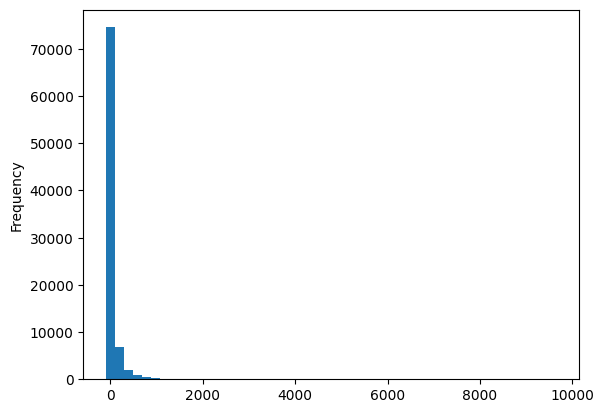

In [15]:
results.profit_loss.plot.hist(bins=50)